In [25]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler, MinMaxScaler
from sklearn import datasets, metrics, model_selection, svm
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
import collections
from sklearn.neighbors import KNeighborsClassifier
from nltk.corpus import stopwords
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score, roc_curve
from collections import Counter
import scikitplot as skplt
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
import lightgbm as lgb
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import RepeatedStratifiedKFold, StratifiedKFold
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings('ignore')
from bs4 import BeautifulSoup
import re
import string
import nltk
from nltk.stem import WordNetLemmatizer

SEED = 4445

Dataset loading↓


In [15]:
data = pd.read_csv("IMDB Dataset.csv", header=0)

# EDA


In [16]:
data.head(-10)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive
...,...,...
49985,Imaginary Heroes is clearly the best film of t...,positive
49986,This movie is a disgrace to the Major League F...,negative
49987,A remake of Alejandro Amenabar's Abre los Ojos...,negative
49988,"When I first tuned in on this morning news, I ...",negative


In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [18]:
data['sentiment'].value_counts()

negative    25000
positive    25000
Name: sentiment, dtype: int64

In [19]:
data.isnull().sum()

review       0
sentiment    0
dtype: int64

In [20]:
review = []

In [21]:
review = data['review'].loc[2]

In [22]:
review

'I thought this was a wonderful way to spend time on a too hot summer weekend, sitting in the air conditioned theater and watching a light-hearted comedy. The plot is simplistic, but the dialogue is witty and the characters are likable (even the well bread suspected serial killer). While some may be disappointed when they realize this is not Match Point 2: Risk Addiction, I thought it was proof that Woody Allen is still fully in control of the style many of us have grown to love.<br /><br />This was the most I\'d laughed at one of Woody\'s comedies in years (dare I say a decade?). While I\'ve never been impressed with Scarlet Johanson, in this she managed to tone down her "sexy" image and jumped right into a average, but spirited young woman.<br /><br />This may not be the crown jewel of his career, but it was wittier than "Devil Wears Prada" and more interesting than "Superman" a great comedy to go see with friends.'

In [53]:
#украл ф-ию со Stackoverflow =)
def create_corpus(word):
    corpus=[]
    
    for x in data[data['sentiment']==word]['review'].str.split():
        for i in x:
            corpus.append(i)
    return corpus
stops=set(stopwords.words('english'))

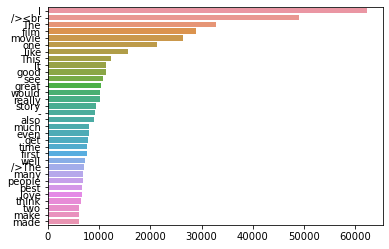

In [26]:
corpus=create_corpus('positive')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

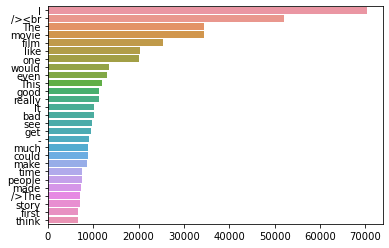

In [27]:
corpus=create_corpus('negative')
counter=Counter(corpus)
most=counter.most_common()
x=[]
y=[]
for word,count in most[:100]:
    if (word not in stops) :
        x.append(word)
        y.append(count)
sns.barplot(x=y,y=x)

Итак, мы наблюдаем хеш-теги html и стоп слова. Время «почистить» дата сет

Используя регулярные выражения, очистим от лишних символов текст. Приведем к нижнему регистру, уберем текст в квадратных скобках, ссылки, слова с цифрами и тд.

In [28]:
def custom_preprocessor(text):

    text = text.lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub("\\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    
    return text

In [29]:
data['review']=data['review'].apply(custom_preprocessor)

In [30]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\plainjane\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [31]:
#лемматизация
def lemma_traincorpus(data):
    lemmatizer=WordNetLemmatizer()
    out_data=""
    for words in data:
        out_data+= lemmatizer.lemmatize(words)
    return out_data

data['review']=data['review'].apply(lambda z: lemma_traincorpus(z))

In [32]:
#data_le = (data_tfidf.replace({'positive': 1, 'negative': 0})).values
#Лейблинг целевой переменной
Labels=[]
for i in range(len(data)):
    if (data['sentiment'][i]=='positive'):
        Labels.append(1)
    else:
        Labels.append(0)
data['target']=Labels



In [33]:
data.head()

,review,sentiment,target
0,one of the other reviewers has mentioned that ...,positive,1
1,a wonderful little production br br the...,positive,1
2,i thought this was a wonderful way to spend ti...,positive,1
3,basically there s a family where a little boy ...,negative,0
4,petter mattei s love in the time of money is...,positive,1


In [34]:
data.drop(['sentiment'] , axis = 1 )

,review,target
0,one of the other reviewers has mentioned that ...,1
1,a wonderful little production br br the...,1
2,i thought this was a wonderful way to spend ti...,1
3,basically there s a family where a little boy ...,0
4,petter mattei s love in the time of money is...,1
...,...,...
49995,i thought this movie did a down right good job...,1
49996,bad plot bad dialogue bad acting idiotic di...,0
49997,i am a catholic taught in parochial elementary...,0
49998,i m going to have to disagree with the previou...,0


In [35]:
#разбиваем данные
X_train, X_test, y_train, y_test = train_test_split(data['review'], 
                                                    data['target'], 
                                                    test_size=0.3, random_state=SEED)

Используем TF-IDF для преобразования слов в вектора.
Стоп слова выбираем для английского языка. Н грамму берем диапозон от 1 до 3 слов. Max_df ставлю 0,9 (если я правильно понял, то 0,9 означает игнорировать слова , встречающииеся больше чем в 90% документах)
Min_df = 0,05 (Слова встречающиеся меньше чем в 5 % документов). 

In [36]:
tfidf_vec=TfidfVectorizer(stop_words='english',ngram_range=(1,3), max_df=0.9, min_df=0.05, norm='l1' )


In [37]:
tfidf_vect_train = tfidf_vec.fit_transform(X_train)
tfidf_vect_test = tfidf_vec.transform(X_test)

In [38]:
print(type(tfidf_vect_train))

<class 'scipy.sparse.csr.csr_matrix'>


#LogReg 

In [39]:
clf_lr = LogisticRegression()

In [40]:
scores = cross_val_score(clf_lr, tfidf_vect_train, y_train, cv=10, n_jobs=4)

In [41]:
clf_lr.fit(tfidf_vect_train, y_train)

LogisticRegression()

In [42]:
predict = clf_lr.predict(tfidf_vect_test)

In [43]:
print("Отчет: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Матрица ошибок: \n", confusion_matrix(y_test, predict))
print("Точность?: \n", accuracy_score(y_test, predict))

Отчет: 
               precision    recall  f1-score   support

    Negative       0.81      0.79      0.80      7559
    Positive       0.79      0.82      0.81      7441

    accuracy                           0.80     15000
   macro avg       0.80      0.80      0.80     15000
weighted avg       0.80      0.80      0.80     15000

Матрица ошибок: 
 [[5973 1586]
 [1356 6085]]
Точность?: 
 0.8038666666666666


In [44]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] } 

In [47]:
clf = GridSearchCV(LogisticRegression(penalty='l2', random_state=SEED, ), param_grid)

In [48]:
clf.fit(tfidf_vect_train, y_train)

GridSearchCV(estimator=LogisticRegression(random_state=4445),
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]})

In [49]:
predict = clf.predict(tfidf_vect_test)

In [50]:
print("Отчет: \n", classification_report(y_test, predict,target_names=['Negative','Positive']))
print("Матрица ошибок: \n", confusion_matrix(y_test, predict))
print("Точность?: \n", accuracy_score(y_test, predict))

Отчет: 
               precision    recall  f1-score   support

    Negative       0.82      0.80      0.81      7559
    Positive       0.80      0.82      0.81      7441

    accuracy                           0.81     15000
   macro avg       0.81      0.81      0.81     15000
weighted avg       0.81      0.81      0.81     15000

Матрица ошибок: 
 [[6017 1542]
 [1324 6117]]
Точность?: 
 0.8089333333333333


In [51]:
probas = clf.predict_proba(tfidf_vect_test)

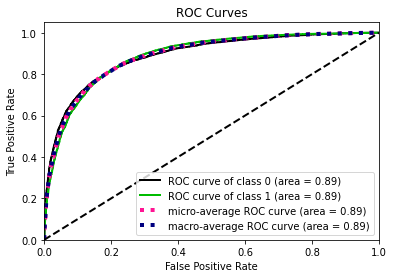

In [52]:
import scikitplot as skplt
skplt.metrics.plot_roc_curve(y_test, probas)
plt.show()